# Péndulo doble

sistema de 4 ecuaciones diferenciales de primer orden con $\alpha_1=\theta_1,\quad \alpha_2=\dot{\theta}_1, \quad\beta=\theta_2, \quad\beta=\dot{\theta}_2$:

\begin{equation}
\dot{\alpha}_1=\alpha_2\\
\dot{\alpha}_2=\frac{g(\sin\beta_1\cos(\alpha_1-\beta_1)-M\sin\alpha_1)-(l_2\beta_2^2+l_1\alpha_2^2\cos(\alpha_1-\beta_1))\sin(\alpha_1-\beta_1)}{l_1(M-\cos^2(\alpha_1-\beta_1)}\\
\dot{\beta}_1=\beta_2\\
\dot{\beta}_2=\frac{gM(\sin\alpha_1\cos(\alpha_1-\beta_1)-\sin\beta_1)-(Ml_1\alpha_2^2+l_2\beta_2^2\cos(\alpha_1-\beta_1))\sin(\alpha_1-\beta_1)}{l_2(M-\cos^2(\alpha_1-\beta_1)}
\end{equation}

In [34]:
# Integración numérica

import sys
import pylab
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.patches import Circle
from scipy import signal
from scipy.fft import fft
from scipy.fft import fftfreq

# Algunas constantes 
l1, l2 = 1, 1
m1, m2 = 1, 1
M = 1 + m1/m2
g = 9.81

#El sistema de ecuaciones diferenciales

def ecuaciones(y, t, l1, l2, m1, m2):
    alpha1, alpha2, beta1, beta2 = y
    
    c, s = np.cos(alpha1-beta1), np.sin(alpha1-beta1)
    
    alpha1dot = alpha2
    
    alpha2dot = (g * (np.sin(beta1) * c - M * np.sin(alpha1)) - (l2 * beta2**2 + l1 * alpha2**2 * c) * s)/(l1 * (M - c**2))
    
    beta1dot = beta2
    
    beta2dot = (g * M * (np.sin(alpha1) * c - np.sin(beta1)) - (M * l1 * alpha2**2 + l2 * beta2**2 * c)* s)/(l2 * (M - c**2))
    
    return alpha1dot, alpha2dot, beta1dot, beta2dot

# tiempo máximo e intervalo de timepo en segundos

tmax, dt = 30, 0.01
t = np.arange(0, tmax+dt, dt)

# Condiciones iniciales: alpha1, dalpha1/dt, beta1, dbeta1/dt.
y0 = np.array([0.6, 0, 0.4, 0])

# Integración numérica de las ecuaciones de movimiento
y = odeint(ecuaciones, y0, t, args=(l1, l2, m1, m2))

In [35]:
y.shape

(3001, 4)

In [36]:
# Unpack los ángulos en función del tiempo
alpha1, beta1 = y[:,0], y[:,2]

# Convertir a coordenadas cartesianas de las dos masas
x1 = l1 * np.sin(alpha1)
y1 = -l1 * np.cos(alpha1)
x2 = x1 + l2 * np.sin(beta1)
y2 = y1 - l2 * np.cos(beta1)

In [ ]:
#plot... i guess 

# Radio de las masas
r = 0.05

# Duración de la visualización de la trayectoria de la masa 2.
trail_secs = 1

# This corresponds to max_trail time points.
max_trail = int(trail_secs / dt)

def make_plot(i):
    # Plot and save an image of the double pendulum configuration for time
    # point i.
    # The pendulum rods.
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k')
    # Circles representing the anchor point of rod 1, and bobs 1 and 2.
    c0 = Circle((0, 0), r/2, fc='k', zorder=10)
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10)
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10)
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    # The trail will be divided into ns segments and plotted as a fading line.
    ns = 20
    s = max_trail // ns

    for j in range(ns):
        imin = i - (ns-j)*s
        if imin < 0:
            continue
        imax = imin + s + 1
        # The fading looks better if we square the fractional length along the
        # trail.
        alpha = (j/ns)**2
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Centre the image on the fixed anchor point, and ensure the axes are equal
    ax.set_xlim(-l1-l2-r, l1+l2+r)
    ax.set_ylim(-l1-l2-r, l1+l2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.savefig('frames/_img{:04d}.png'.format(i//di), dpi=72)
    plt.cla()


# Make an image every di time points, corresponding to a frame rate of fps
# frames per second.
# Frame rate, s-1
fps = 10
di = int(1/fps/dt)
fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

for i in range(0, t.size, di):
    print(i // di, '/', t.size // di)
    make_plot(i)

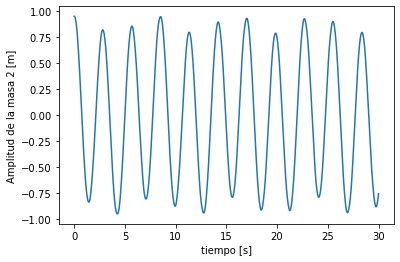

In [37]:
#la amplitud de la masa 2

plt.plot(t, x2)
plt.ylabel('Amplitud de la masa 2 [m]')
plt.xlabel('tiempo [s]')
plt.savefig('x_0.6 0.4.png')
plt.show()


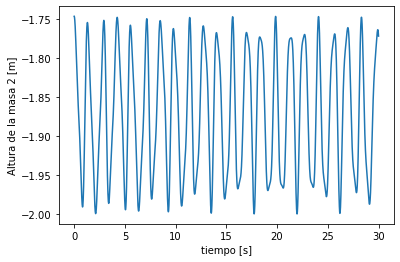

In [38]:
#amplitud de la masa 2, pero en y

plt.plot(t, y2)
plt.ylabel('Altura de la masa 2 [m]')
plt.xlabel('tiempo [s]')
plt.savefig('y_0.6 0.4.png')
plt.show()

#The gif 

from pathlib import Path
import imageio

image_path = Path('/home/nicole/Documents/books/modelado y simulación/trabajo5 caos?/frames')

images = list(image_path.glob('*.png'))

image_list = []

for file_name in images:
    image_list.append(imageio.imread(file_name))
    
imageio.mimwrite('animated_from_images.gif', image_list, duration = 0.5) #ugh... whatever, didn't work

In [39]:
#coeficientes de la expansión en fourier de la amplitud de la masa 2

y_coeff = np.fft.rfft(y2)   #para altura y

x_coeff = np.fft.rfft(x2)   #para amplitud

y_coeff[0]

(-5613.547993896013+0j)

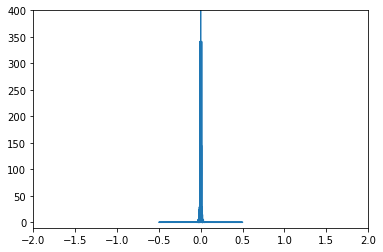

In [27]:
#Transformada de fourier

yf = np.fft.fft(y2)
freq = np.fft.fftfreq(t.shape[-1])
    
plt.plot(freq, abs(yf.real))
plt.xlim([-2, 2])
plt.ylim(-10, 400)

plt.show()

In [40]:
#otra transformada de fourier, creo que esta está mejor.

N = len(t)
dt = t[1]-t[0]

# calculate the fast fourier transform
Fy = fft(y2)   #para altura
Fx = fft(x2)   #para amplitud

# calculate the frequencies for the components in F
w = fftfreq(N, dt)

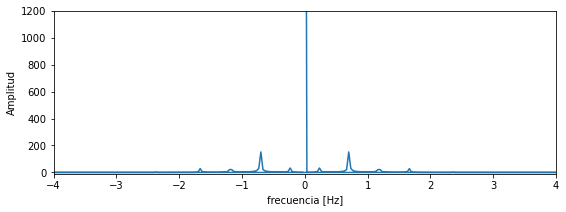

In [41]:
fig, ax = pylab.subplots(figsize=(9,3))
plt.ylabel('Amplitud')
plt.xlabel('frecuencia [Hz]')
plt.xlim([-4, 4])
plt.ylim(-10, 1200)
ax.plot(w, abs(Fy))
plt.savefig('y_fourier_0.6 0.4.png')

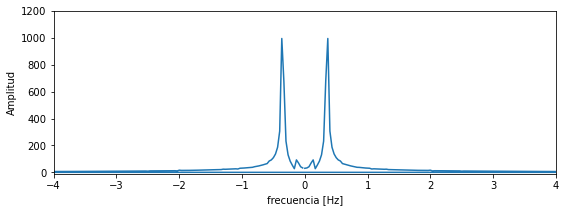

In [42]:
fig, ax = pylab.subplots(figsize=(9,3))
plt.ylabel('Amplitud')
plt.xlabel('frecuencia [Hz]')
plt.xlim([-4, 4])
plt.ylim(-10, 1200)
ax.plot(w, abs(Fx))
plt.savefig('x_fourier_0.6 0.4.png')

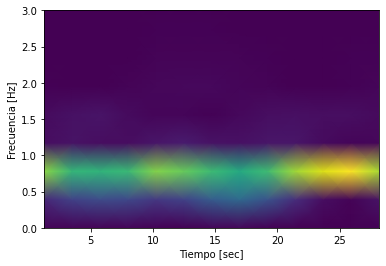

In [43]:
fs = 100

f, t1, Sxx = signal.spectrogram(y2, fs)
plt.pcolormesh(t1, f, Sxx, shading='gouraud')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [sec]')
plt.ylim([0, 3])
plt.savefig('y_spect_0.6 0.4.png')
plt.show()

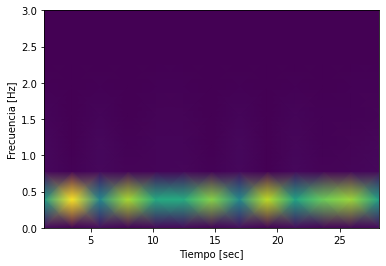

In [44]:
f, t1, Sxx = signal.spectrogram(x2, fs)
plt.pcolormesh(t1, f, Sxx, shading='gouraud')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [sec]')
plt.ylim([0, 3])
plt.savefig('x_spect_0.6 0.4.png')
plt.show()

# Sistema linealizado

\begin{equation}
\dot{\theta_1}=\gamma_1\\
\dot{\gamma}_1=\frac{g(\theta_2-M\theta_1)}{l_1(M-1)}\\
\dot{\theta_2}=\gamma_2\\
\dot{\gamma}_2=\frac{gM\Delta\theta}{l_2(M-1)}
\end{equation}

In [53]:
def ecuaciones_lin(y, t, l1, l2, m1, m2):
    theta1, theta2, gamma1, gamma2 = y
    
    delta = (alpha1-beta1)
    
    theta1dot = gamma1
    
    gamma1dot = (g * (theta2 - M * theta1))/(l1 * (M - 1))
    
    beta1dot = beta2
    
    beta2dot = (g * M * delta)/(l2 * (M - 1))
    
    return alpha1dot, alpha2dot, beta1dot, beta2dot

# Condiciones iniciales: alpha1, dalpha1/dt, beta1, dbeta1/dt.
y0_lin = np.array([np.pi/8, 0, np.pi/7, 0])

# Integración numérica de las ecuaciones de movimiento
y_lin = odeint(ecuaciones, y0_lin, t, args=(l1, l2, m1, m2))

# Unpack los ángulos en función del tiempo
alpha1_lin, beta1_lin = y_lin[:,0], y_lin[:,2]

# Convertir a coordenadas cartesianas de las dos masas
x1_lin = l1 * np.sin(alpha1_lin)
y1_lin = -l1 * np.cos(alpha1_lin)
x2_lin = x1_lin + l2 * np.sin(beta1_lin)
y2_lin = y1_lin - l2 * np.cos(beta1_lin)

0 / 300
1 / 300
2 / 300
3 / 300
4 / 300
5 / 300
6 / 300
7 / 300
8 / 300
9 / 300
10 / 300
11 / 300
12 / 300
13 / 300
14 / 300
15 / 300
16 / 300
17 / 300
18 / 300
19 / 300
20 / 300
21 / 300
22 / 300
23 / 300
24 / 300
25 / 300
26 / 300
27 / 300
28 / 300
29 / 300
30 / 300
31 / 300
32 / 300
33 / 300
34 / 300
35 / 300
36 / 300
37 / 300
38 / 300
39 / 300
40 / 300
41 / 300
42 / 300
43 / 300
44 / 300
45 / 300
46 / 300
47 / 300
48 / 300
49 / 300
50 / 300
51 / 300
52 / 300
53 / 300
54 / 300
55 / 300
56 / 300
57 / 300
58 / 300
59 / 300
60 / 300
61 / 300
62 / 300
63 / 300
64 / 300
65 / 300
66 / 300
67 / 300
68 / 300
69 / 300
70 / 300
71 / 300
72 / 300
73 / 300
74 / 300
75 / 300
76 / 300
77 / 300
78 / 300
79 / 300
80 / 300
81 / 300
82 / 300
83 / 300
84 / 300
85 / 300
86 / 300
87 / 300
88 / 300
89 / 300
90 / 300
91 / 300
92 / 300
93 / 300
94 / 300
95 / 300
96 / 300
97 / 300
98 / 300
99 / 300
100 / 300
101 / 300
102 / 300
103 / 300
104 / 300
105 / 300
106 / 300
107 / 300
108 / 300
109 / 300
110 / 300


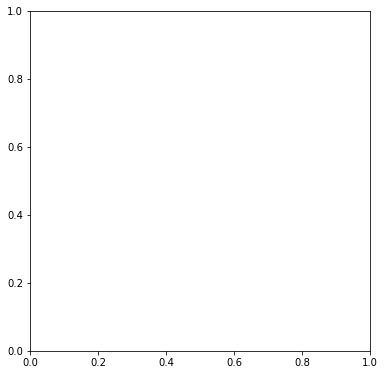

In [54]:
# Radio de las masas
r = 0.05

# Duración de la visualización de la trayectoria de la masa 2.
trail_secs = 1

# This corresponds to max_trail time points.
max_trail = int(trail_secs / dt)

def make_plot(i):
    # Plot and save an image of the double pendulum configuration for time
    # point i.
    # The pendulum rods.
    ax.plot([0, x1_lin[i], x2_lin[i]], [0, y1_lin[i], y2_lin[i]], lw=2, c='k')
    # Circles representing the anchor point of rod 1, and bobs 1 and 2.
    c0 = Circle((0, 0), r/2, fc='k', zorder=10)
    c1 = Circle((x1_lin[i], y1_lin[i]), r, fc='b', ec='b', zorder=10)
    c2 = Circle((x2_lin[i], y2_lin[i]), r, fc='r', ec='r', zorder=10)
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    # The trail will be divided into ns segments and plotted as a fading line.
    ns = 20
    s = max_trail // ns

    for j in range(ns):
        imin = i - (ns-j)*s
        if imin < 0:
            continue
        imax = imin + s + 1
        # The fading looks better if we square the fractional length along the
        # trail.
        alpha = (j/ns)**2
        ax.plot(x2_lin[imin:imax], y2_lin[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Centre the image on the fixed anchor point, and ensure the axes are equal
    ax.set_xlim(-l1-l2-r, l1+l2+r)
    ax.set_ylim(-l1-l2-r, l1+l2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.savefig('frames_lin/_img{:04d}.png'.format(i//di), dpi=72)
    plt.cla()


# Make an image every di time points, corresponding to a frame rate of fps
# frames per second.
# Frame rate, s-1
fps = 10
di = int(1/fps/dt)
fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

for i in range(0, t.size, di):
    print(i // di, '/', t.size // di)
    make_plot(i)

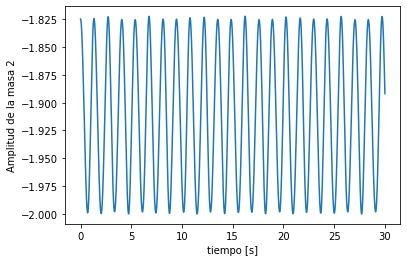

In [55]:
#la amplitud de la masa 2

plt.plot(t, y2_lin)
plt.ylabel('Amplitud de la masa 2')
plt.xlabel('tiempo [s]')
plt.show()

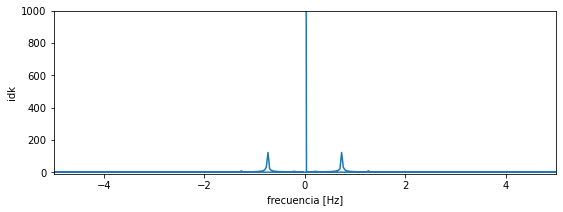

In [57]:
#transformada de fourier, creo que esta está mejor.

N = len(t)
dt = t[1]-t[0]

# calculate the fast fourier transform
F = fft(y2_lin) 

# calculate the frequencies for the components in F
w = fftfreq(N, dt)

fig, ax = pylab.subplots(figsize=(9,3))
plt.ylabel('idk')
plt.xlabel('frecuencia [Hz]')
plt.xlim([-5, 5])
plt.ylim(-10, 1000)
ax.plot(w, abs(F))

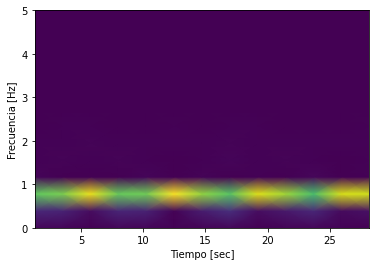

In [58]:
fs = 100

f, t1, Sxx = signal.spectrogram(y2_lin, fs)

plt.pcolormesh(t1, f, Sxx, shading='gouraud')

plt.ylabel('Frecuencia [Hz]')

plt.xlabel('Tiempo [sec]')

plt.ylim([0, 5])

plt.show()